In [113]:
__author__ = "me"
__date__ = "2015_10_13"
%pylab inline

import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


CUSP = os.getenv('CUSP_DIR')





from os import walk

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
def getAllFiles(path, frmt=None, full=False):
    '''return all files in the folder,
    filtered by format, if it was provided'''
    
    fs = []
    for (dirpath, dirnames, filenames) in walk(path):
        if frmt!=None:
            fsTmp = [fl for fl in filenames if fl.endswith(frmt)]
            fs.extend(fsTmp)
        else:
            fsTmp = filenames
            fs.extend(fsTmp)
    if full:
        return [path+f for f in fs]
    else:
        return fs

In [7]:
path = CUSP + '1_2_CAUI/CA_project1/transport/turnstiles_data/'
files = getAllFiles(path,'.csv', full=1)

In [8]:
## unfortunately data has different structure after 11.10.2014
before = []
after = []

b = False
for f in files:
    if not b:
        before.append(f)
        if '141011' in f: b = True
    else:
        after.append(f)

print len(before)
print len(after)

106
54


In [9]:
def dfManyNoHeaders(fs):
    dfs  = []

    for f in fs:
        df = pd.read_csv(f, header=None, index_col=0)
        dfs.append(df)

    return pd.concat(dfs)
    
def dfManyHeaders(fs):
    dfs  = []

    for f in fs:
        df = pd.read_csv(f, index_col=0)
        dfs.append(df)

    return pd.concat(dfs)

In [10]:
dfa = dfManyHeaders(after)
dfb = dfManyNoHeaders(before)

/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (8,13,18,23,28,33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
## also we hade to "split and concat old datasets as the structure is very ugly"
dfbs= []
# dfb.rename(columns={1:'C/A',2:'UNIT',3:'SCP'},inplace=1)
for i in xrange(8):
    x = pd.concat([dfb.ix[:,:3], dfb.ix[:,(5*i+4):(5*i+8)]],1)
    x.columns = ['C/A','UNIT','SCP','DATE', 'TIME','DESC','ENTRIES','EXITS' ]                                                       
    dfbs.append(x)

dfbe = pd.concat(dfbs)

In [12]:
print len(dfbe)
dfbe2 = dfbe.dropna(how='any')
print len(dfbe2)

24935480
23061926


In [19]:
dfbe2.head()

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS
0,,,,,,,,
NaN,A002,R051,02-00-00,09-15-12,00:00:00,REGULAR,3796719,1309457
0,A002,R051,02-00-00,09-16-12,08:00:00,REGULAR,3797349,1309786
1,A002,R051,02-00-00,09-17-12,16:00:00,REGULAR,3798214,1310318
2,A002,R051,02-00-00,09-19-12,00:00:00,REGULAR,3800414,1310865
3,A002,R051,02-00-00,09-20-12,08:00:00,REGULAR,3802038,1311486


In [13]:
dfa.columns = [x.strip() for x in dfa.columns]

In [14]:
dfe = pd.concat([dfbe2,dfa])
dfe.head()

,C/A,DATE,DESC,DIVISION,ENTRIES,EXITS,LINENAME,SCP,STATION,TIME,UNIT
0,,,,,,,,,,,
NaN,A002,09-15-12,REGULAR,NaN,3796719,1309457,NaN,02-00-00,NaN,00:00:00,R051
0,A002,09-16-12,REGULAR,NaN,3797349,1309786,NaN,02-00-00,NaN,08:00:00,R051
1,A002,09-17-12,REGULAR,NaN,3798214,1310318,NaN,02-00-00,NaN,16:00:00,R051
2,A002,09-19-12,REGULAR,NaN,3800414,1310865,NaN,02-00-00,NaN,00:00:00,R051
3,A002,09-20-12,REGULAR,NaN,3802038,1311486,NaN,02-00-00,NaN,08:00:00,R051


## AGGREGATE TO MAX_DAY

In [15]:
# we dont need time for now
# dfe['TIMESTAMP'] = dfe.DATE + ' '+ dfe.TIME

In [161]:
tiny_data = dfe[['C/A','UNIT', 'DATE','TIME','ENTRIES','EXITS']]

In [162]:
# tiny_data.DATE = pd.to_datetime(tiny_data.DATE)

In [163]:
BH = tiny_data[tiny_data.UNIT == 'R108']
HO = tiny_data[tiny_data.UNIT == 'R217']
JA = tiny_data[tiny_data.UNIT == 'R089']

In [164]:
print len(BH)
print len(HO)
print len(JA)

194749
37605
66449


In [ ]:
def getTiming(df):
    
    

In [50]:
def daySeries(df):
    '''group metrodata by day (max by day) and parse date'''
    df_day = df.groupby(['DATE']).agg({'ENTRIES':max,'EXITS':max}).reset_index()
    df_day.DATE = pd.to_datetime(df_day.DATE)
    df_day.ENTRIES = pd.to_numeric(df_day.ENTRIES)
    df_day.EXITS = pd.to_numeric(df_day.EXITS)
    return df_day

In [51]:
BH_day = daySeries(BH)
HO_day = daySeries(HO)
JA_day = daySeries(JA)
BH_day.head()

,DATE,EXITS,ENTRIES
0,2013-01-01,10348375,13233424
1,2014-01-01,11532114,100695369
2,2013-01-02,10350393,13236252
3,2014-01-02,11537223,100695494
4,2013-01-03,10352545,13239236


In [52]:
print len(BH_day[pd.isnull(BH_day.ENTRIES)])
print len(HO_day[pd.isnull(HO_day.ENTRIES)])
print len(JA_day[pd.isnull(JA_day.ENTRIES)])

0
0
0


In [76]:
BH_dayX = BH_day.set_index('DATE').sort_index().diff(axis=0)
HO_dayX = HO_day.set_index('DATE').sort_index().diff(axis=0)
JA_dayX = JA_day.set_index('DATE').sort_index().diff(axis=0)


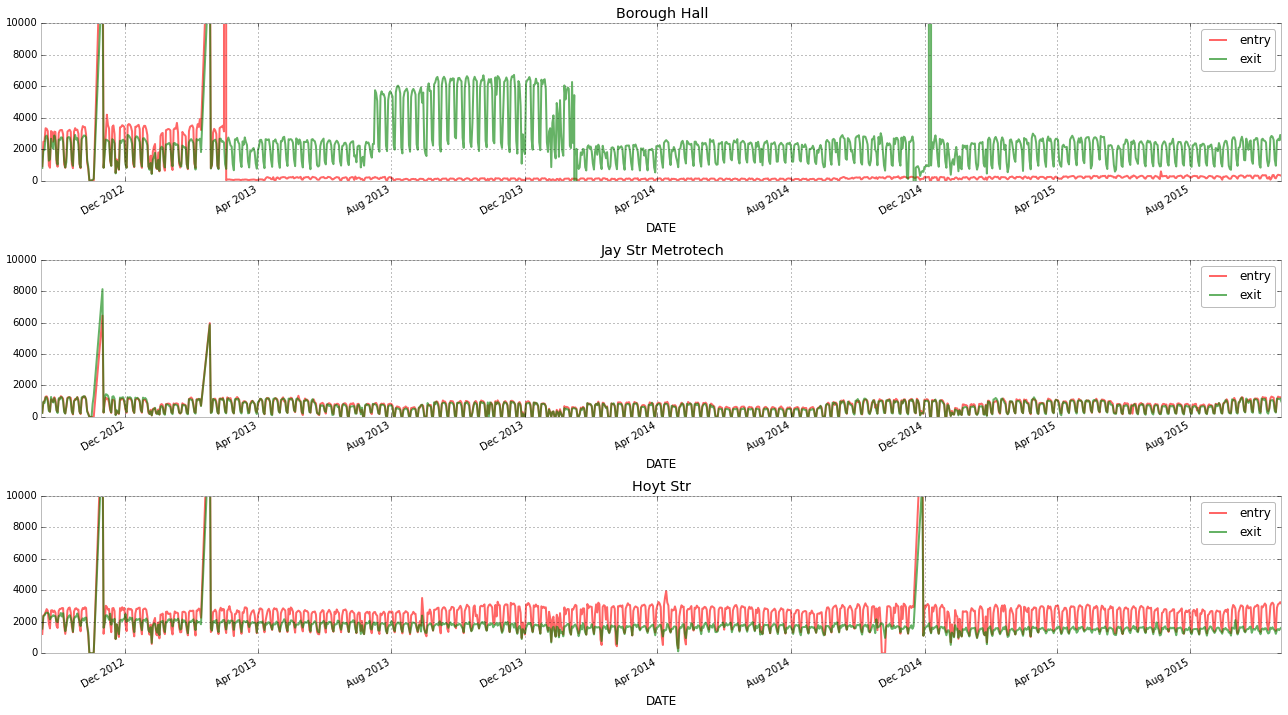

In [90]:
fig, axes = plt.subplots(nrows=3, figsize=(18,10))


BH_dayX.ENTRIES.plot(kind='line', color='r', alpha=.6, ylim=(0,10000), ax=axes[0], label='entry', title='Borough Hall')
BH_dayX.EXITS.plot(kind='line', color='g',alpha=.6, ylim=(0,10000), ax=axes[0], label='exit')
axes[0].legend()
JA_dayX.ENTRIES.plot(kind='line', color='r',alpha=.6,  ylim=(0,10000), ax=axes[1], label='entry', title='Jay Str Metrotech')
JA_dayX.EXITS.plot(kind='line', color='g',alpha=.6,  ylim=(0,10000), ax=axes[1], label='exit')
axes[1].legend()
HO_dayX.ENTRIES.plot(kind='line', color='r', alpha=.6, ylim=(0,10000), ax=axes[2], label='entry', title='Hoyt Str')
HO_dayX.EXITS.plot(kind='line', color='g', alpha=.6, ylim=(0,10000), ax=axes[2], label='exit')
axes[2].legend()
plt.tight_layout()

plt.savefig(CUSP + '1_2_CAUI/CA_project1/transport/subway_dayly.png')

In [ ]:
def getWeekly(df):
        df['wd'] = df.index.weekday
        df = df.groupby('wd').agg(median).sort_index()
        return df

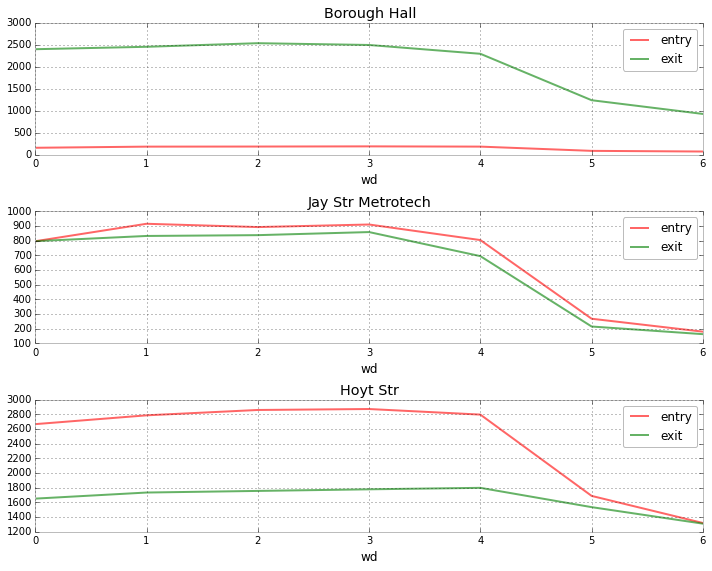

In [138]:
fig, axes = plt.subplots(nrows=3, figsize=(10,8))

getWeekly(BH_dayX).ENTRIES.plot(kind='line',alpha=.6, color='r', ax=axes[0], label='entry', title='Borough Hall')
getWeekly(BH_dayX).EXITS.plot(kind='line',alpha=.6, color='g', ax=axes[0], label='exit');
axes[0].legend()
getWeekly(JA_dayX).ENTRIES.plot(kind='line',alpha=.6, color='r', ax=axes[1], label='entry', title='Jay Str Metrotech')
getWeekly(JA_dayX).EXITS.plot(kind='line', alpha=.6, color='g', ax=axes[1], label='exit');
axes[1].legend()
getWeekly(HO_dayX).ENTRIES.plot(kind='line', alpha=.6, color='r', ax=axes[2], label='entry', title='Hoyt Str')
getWeekly(HO_dayX).EXITS.plot(kind='line',alpha=.6, color='g', ax=axes[2], label='exit');
axes[2].legend()
plt.tight_layout()

plt.savefig(CUSP + '1_2_CAUI/CA_project1/transport/subway_week.png')

In [136]:
def byMonth(df):
    return df.resample("M", how='median')
#     df['mnth'] = df.index.month
#     df = df.groupby('mnth').agg(mean).sort_index()

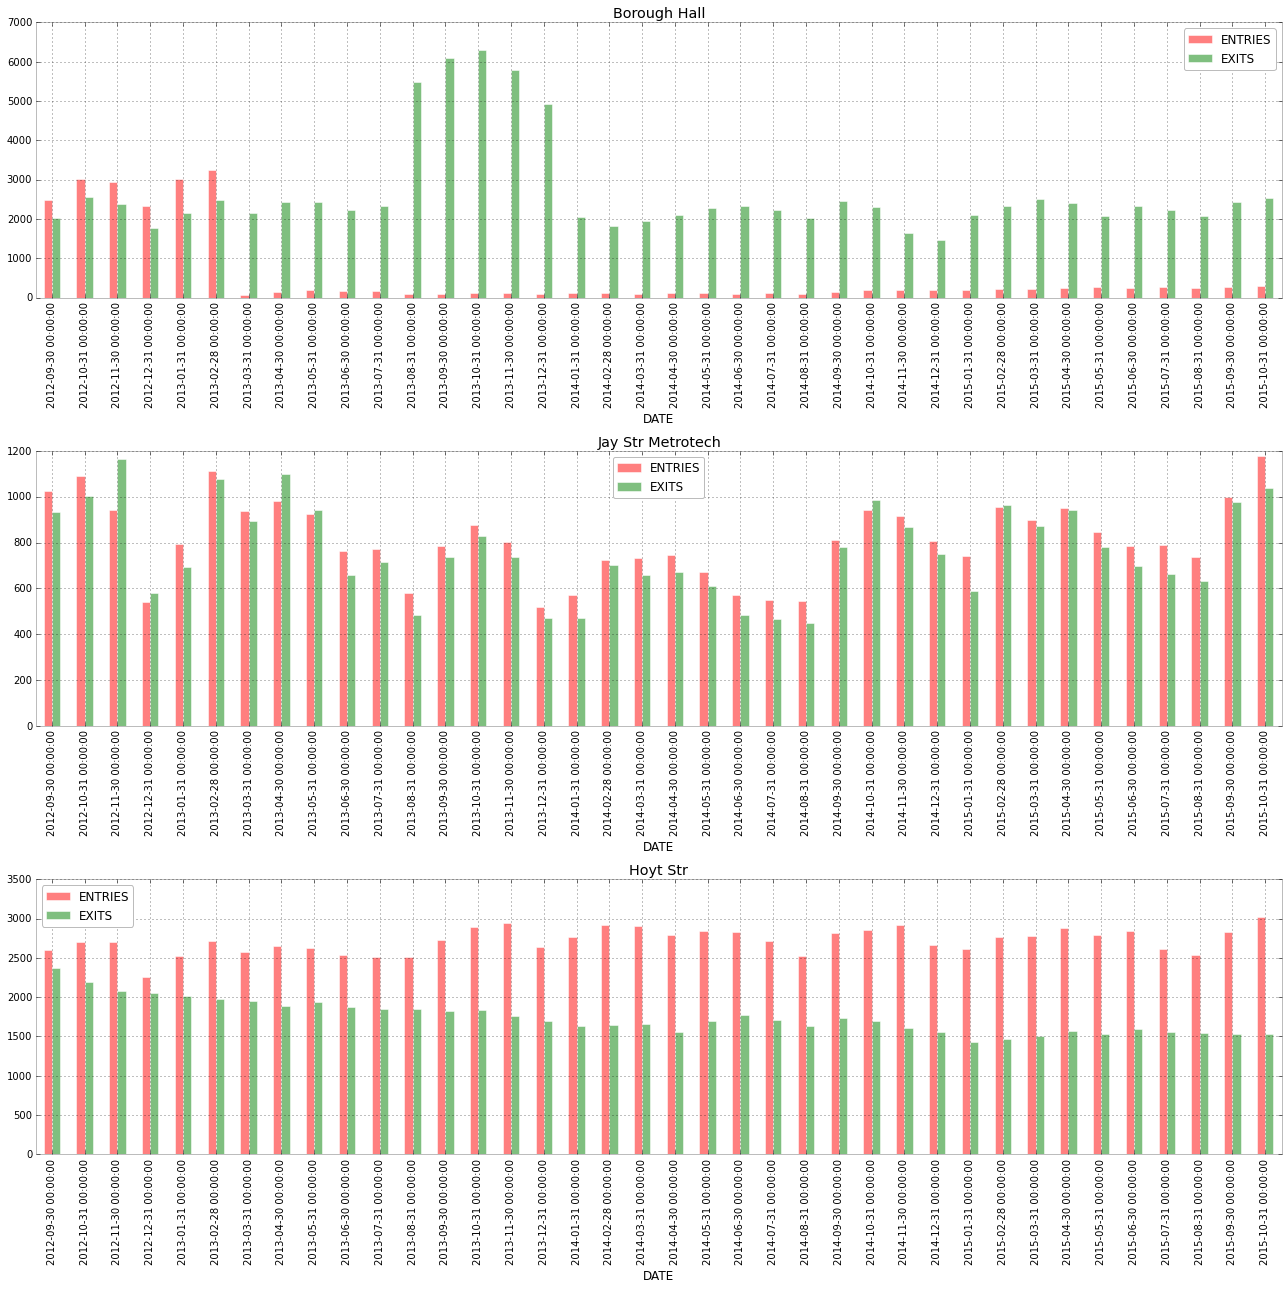

In [158]:
fig, axes = plt.subplots(nrows=3, figsize=(18,18))

# byMonth(BH_dayX).ENTRIES.plot(kind='line',alpha=.6, color='r', ax=axes[0], label='entry', title='Borough Hall')
# byMonth(BH_dayX).EXITS.plot(kind='line',alpha=.6, color='g', ax=axes[0], label='exit');
# axes[0].legend()

byMonth(BH_dayX)[['ENTRIES','EXITS']].plot(kind='bar',ax = axes[0], color=('r','g'), alpha=.5, title='Borough Hall')
byMonth(JA_dayX)[['ENTRIES','EXITS']].plot(kind='bar',ax = axes[1], color=('r','g'), alpha=.5, title='Jay Str Metrotech')
byMonth(HO_dayX)[['ENTRIES','EXITS']].plot(kind='bar',ax = axes[2], color=('r','g'), alpha=.5, title='Hoyt Str')
plt.tight_layout()

plt.savefig(CUSP + '1_2_CAUI/CA_project1/transport/subway_month.png')